## 1. Load packages

In [170]:
# data processing packages
import numpy as np
from numpy import random
import pandas as pd
import re

# machine learning packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# visualization packages
import seaborn as sb
import matplotlib.pyplot as plt

# other packages
import torch
from pathlib import Path
import random
import itertools
import time

## 2. Read the files

In [2]:
## Create the necessary folders
Path('./Figures/').mkdir(parents=True, exist_ok=True)
Path('./Results/').mkdir(parents=True, exist_ok=True)

In [3]:
## Set path to the data set
dataset_path = "./dataset/77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "./dataset/clinical_data_breast_cancer.csv"
pam50_proteins = "./dataset/PAM50_proteins.csv"

## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical_file = pd.read_csv(clinical_info,header=0,index_col=0) ## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

# RefSeq protein ID (each protein has a unique ID in a RefSeq database)
print(data.index.name)
data.head()

RefSeq_accession_number


,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


## 3. Data Set Processing

In [4]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

data.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [5]:
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
print(data.shape)
datat = data.transpose()
print(datat.shape)

datat.head()

(12553, 83)
(83, 12553)


RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [6]:
print("Number of patients in clinical data set: ", len(clinical_file.index))
print("Number of patients in protein data set: ", len(datat.index))

Number of patients in clinical data set:  105
Number of patients in protein data set:  83


In [7]:
## Drop clinical entries for samples not in our protein data set
clinical = clinical_file.loc[[x for x in clinical_file.index.tolist() if x in datat.index],:]

print("The shape of the clinical data set: ", clinical.shape)
clinical.head()

The shape of the clinical data set:  (77, 29)


,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [8]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = datat.merge(clinical,left_index=True,right_index=True)

# Drop the duplicated columns (added by Pietro Gavazzi)
liste = merged.index.copy()
liste = list(liste)

for i in np.unique(merged.index):
    liste.remove(i)

## Change name to make it look nicer in the code!
processed = merged.drop(np.unique(liste))

print("Shape of the merged data set: ", processed.shape)
print("with %d patients and %d features" % (processed.shape[0], processed.shape[1]))

processed.head()

Shape of the merged data set:  (74, 12582)
with 74 patients and 12582 features


,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4


In [9]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
X = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_|YP_",x)) == True]]
Y = pd.get_dummies(processed.drop(X.columns, axis=1)['Integrated Clusters (with PAM50)'], prefix="PAM50")

## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
# processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
# processed_numerical_p50.head()

X.columns

Index(['NP_958782', 'NP_958785', 'NP_958786', 'NP_000436', 'NP_958781',
       'NP_958780', 'NP_958783', 'NP_958784', 'NP_112598', 'NP_001611',
       ...
       'NP_001193600', 'NP_061134', 'NP_932347', 'NP_003593', 'NP_997203',
       'NP_001191293', 'NP_775791', 'NP_004065', 'NP_068752', 'NP_219494'],
      dtype='object', length=12553)

In [10]:
Y.head()

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0


In [11]:
# Save the data
torch.save(X, './Results/X')
torch.save(Y, './Results/Y')

## 3. Data Engineering

In [12]:
# Read the processed data set
X = torch.load('./Results/X')
Y = torch.load('./Results/Y')

In [13]:
X.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.106650,NaN,-6.941181
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.801685,NaN,NaN,3.802310,-6.373934,-1.123160,NaN,NaN,NaN,NaN
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,NaN,NaN


In [14]:
Y.head()

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0


### 3.1 Missing value process
We drop all the columns with nan values

In [15]:
nan_counts = np.sum(X.isna(), axis=0)
col_to_drop = nan_counts[nan_counts != 0].index
X.drop(col_to_drop, axis=1, inplace=True)

In [16]:
X.shape

(74, 8023)

### 3.2 Data Scaling
We use the standardization for each feature of the data set

In [17]:
col_names = X.columns
idx = X.index
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=col_names, index=idx)
X_scaled.shape

(74, 8023)

## 4. Basic model

### 4.1 K-Means model

In [18]:
kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_scaled)
pred0 = kmeans.labels_

### 4.2 Evaluation Metric

In [19]:

# https://medium.com/data-science-in-your-pocket/calculating-precision-recall-for-multi-class-classification-9055931ee229 


permutation_matrices = []
for i in itertools.permutations([0, 1, 2, 3]):
    matrix = np.zeros((4, 4))
    for j in range(len(matrix)):
        matrix[j][i[j]] = 1

    permutation_matrices.append(matrix)



def get_dataframe(y_array_pred, y_true):
    pred = pd.DataFrame(pd.get_dummies(y_array_pred))
    pred.columns = ['cluster_' + str(x) for x in range(1, 5)]
    pred = pred.set_index(y_true.index)
    return(pred)



def calculate_mean_prec(matrix):
    matrix = np.array(matrix)
    assert(matrix.shape[0]==matrix.shape[1]), f"matrix must be squared, same number of true labels {matrix.shape[0]} as predicted{matrix.shape[1]}"

    prec = np.zeros(len(matrix))

    for i in range(len(matrix)):
        true_pos_classified_pos = matrix[i][i]
        classified_pos= np.sum(matrix[i])
        prec[i] = true_pos_classified_pos/classified_pos
    
    return np.mean(prec)

def calculate_mean_recall(matrix):
    matrix = np.array(matrix)
    assert(matrix.shape[0]==matrix.shape[1]), f"matrix must be squared, same number of true labels {matrix.shape[0]} as predicted{matrix.shape[1]}"

    rec = np.zeros(len(matrix.T))

    for i in range(len(matrix.T)):
        true_pos_classified_pos = matrix.T[i][i]
        true_pos= np.sum(matrix.T[i])
        rec[i] = true_pos_classified_pos/true_pos

    return np.mean(rec)


def model_eval(y_true, y_pred):

    length = len(y_true.T)
    assert (y_pred.shape==y_true.shape), f"expected same shape of colums for both y_true: {y_true.shape} and y_pred {y_pred.shape}"
    
    matrix = np.zeros((length, length))

    indi = 0
    for i in y_pred.T.index:
        indj = 0
        for j in y_true.T.index:
            matrix[indi][indj] += np.array(y_pred[i]) @ np.array(y_true[j])
            indj+=1
        indi+=1

    
    matrix = pd.DataFrame(matrix, columns=y_true.T.index, index=y_pred.T.index)


    best_perm = None
    best_Fscore = 0
    best_prec = 0
    best_rec = 0

    ## version 3.0
    for permu_mat in permutation_matrices:
        M = permu_mat@matrix

        prec = calculate_mean_prec(M)
        rec = calculate_mean_recall(M)

        Fscore = 2/(1/prec + 1/rec)
        
        if Fscore > best_Fscore:
            best_perm = permu_mat
            best_Fscore = Fscore
            best_prec = prec
            best_rec = rec
    
    new_matrix = best_perm@matrix

    indexes = []
    for i in range(len(best_perm)):
        for j in range(len(best_perm)):
            if best_perm[i][j]==1:
                indexes.append(matrix.index[j])


    new_matrix.index = indexes

    return new_matrix, best_Fscore, best_prec, best_rec

In [20]:
y_pred = get_dataframe(pred0, Y)
new_matrix, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)
new_matrix

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
cluster_3,4.0,0.0,3.0,3.0
cluster_1,2.0,10.0,2.0,6.0
cluster_2,3.0,6.0,12.0,7.0
cluster_4,1.0,2.0,6.0,7.0


In [21]:
best_Fscore

0.4434556998037695

## 5. Model improvement

### 5.1 Feature selection

#### 5.1.1 One feature selection

In [25]:
Fscor_list = []
max_Fscore = 0
feature_selected = None

for i in range(X_scaled.shape[1]):
    print(i, "/", X_scaled.shape[1])
    X_reduced = np.array(X_scaled.iloc[:, i]).reshape(-1, 1)
    k_means = KMeans(n_clusters=4).fit(X_reduced)
    pred_ = k_means.labels_
    y_pred_ = get_dataframe(pred_, Y)
    _, Fscore, prec, rec = model_eval(Y, y_pred_)
    Fscor_list.append(Fscore)

    if Fscore > max_Fscore:
        max_Fscore = Fscore
        feature_selected = X_scaled.columns[i]

print(max_Fscore)
print(feature_selected)

0 / 8023
1 / 8023
2 / 8023
3 / 8023
4 / 8023
5 / 8023
6 / 8023
7 / 8023
8 / 8023
9 / 8023
10 / 8023
11 / 8023
12 / 8023
13 / 8023
14 / 8023
15 / 8023
16 / 8023
17 / 8023
18 / 8023
19 / 8023
20 / 8023
21 / 8023
22 / 8023
23 / 8023
24 / 8023
25 / 8023
26 / 8023
27 / 8023
28 / 8023
29 / 8023
30 / 8023
31 / 8023
32 / 8023
33 / 8023
34 / 8023
35 / 8023
36 / 8023
37 / 8023
38 / 8023
39 / 8023
40 / 8023
41 / 8023
42 / 8023
43 / 8023
44 / 8023
45 / 8023
46 / 8023
47 / 8023
48 / 8023
49 / 8023
50 / 8023
51 / 8023
52 / 8023
53 / 8023
54 / 8023
55 / 8023
56 / 8023
57 / 8023
58 / 8023
59 / 8023
60 / 8023
61 / 8023
62 / 8023
63 / 8023
64 / 8023
65 / 8023
66 / 8023
67 / 8023
68 / 8023
69 / 8023
70 / 8023
71 / 8023
72 / 8023
73 / 8023
74 / 8023
75 / 8023
76 / 8023
77 / 8023
78 / 8023
79 / 8023
80 / 8023
81 / 8023
82 / 8023
83 / 8023
84 / 8023
85 / 8023
86 / 8023
87 / 8023
88 / 8023
89 / 8023
90 / 8023
91 / 8023
92 / 8023
93 / 8023
94 / 8023
95 / 8023
96 / 8023
97 / 8023
98 / 8023
99 / 8023
100 / 8023

In [26]:
# The best performance of selecting only one feature is to select 'NP_005424'
# feature_selected = ["NP_005424"]
X_reduced = np.array(X_scaled[feature_selected]).reshape(-1, 1)
k_means = KMeans(n_clusters=4).fit(X_reduced)
pred = k_means.labels_
y_pred = get_dataframe(pred, Y)
_, Fscore, prec, rec = model_eval(Y, y_pred)

In [27]:
Fscore

0.5715692124105012

#### 5.1.2 Multiple feature selection

We will test the performance of slecting each number of features(1 feature to 8023 features). We will compute the average of the performance, including precision, recall and f-score, and save them into torch format files, based on a random selection of features 50 times for each number of features.

In [64]:
def feature_selection(X_scaled, Y, min_features, max_features):
    random.seed(42)

    mean_prec_list, std_prec_list = [], []
    mean_rec_list, std_rec_list = [], []
    mean_Fscore_list, std_Fscore_list = [], []

    for num_feature in range(min_features, max_features+1):
        prec_list, rec_list, Fscore_list = [], [], []
        for i in range(50):
            tic = time.time()
            feature_selected = random.choices(X_scaled.columns, k=num_feature)
            if num_feature == 1:
                X_reduced = np.array(X_scaled[feature_selected]).reshape(-1, 1)
            else:
                X_reduced = np.array(X_scaled[feature_selected])
            k_means = KMeans(n_clusters=4).fit(X_reduced)
            pred = k_means.labels_
            y_pred = get_dataframe(pred, Y)
            _, Fscore, prec, rec = model_eval(Y, y_pred)

            prec_list.append(prec)
            rec_list.append(rec)
            Fscore_list.append(Fscore)
            tac = time.time()

            print("[# features: %d] [random attemps: %d] [prec: %.4f] [rec: %.4f] [F-score: %.4f] [T: %.2f]" % (
                num_feature, i, prec, rec, Fscore, (tac-tic)
            ))

        mean_prec_list.append(np.mean(prec_list))
        std_prec_list.append(np.std(prec_list))

        mean_rec_list.append(np.mean(rec_list))
        std_rec_list.append(np.std(rec_list))

        mean_Fscore_list.append(np.mean(Fscore_list))
        std_Fscore_list.append(np.std(Fscore_list))

    return [mean_prec_list, std_prec_list, mean_rec_list, std_rec_list, mean_Fscore_list, std_Fscore_list]

In [65]:
# for i in range(1, 81):
#     results_i = feature_selection(X_scaled, Y, (i-1)*100+1, i*100)
#     torch.save(results_i, './Results/results_' + str((i-1)*100+1) + '_' + str(i*100))
# result_8001_8023 = feature_selection(X_scaled, Y, 8001, 8023)
# torch.save(result_8001_8023, './Results/results_8001_8023')

In [160]:
file_list = pd.DataFrame(sorted(Path('./Results').glob('results_*')), columns=['file_name'])
file_list['max'] = file_list['file_name'].apply(lambda x: eval(str(x).split('_')[-1]) )
file_list.sort_values('max', inplace=True)
file_list = file_list['file_name'].values.tolist()

scores = pd.DataFrame([], columns = ['mean_prec_list', 'std_prec_list', 'mean_rec_list', 'std_rec_list', 'mean_Fscore_list', 'std_Fscore_list'])
for file in file_list:
    result = torch.load(file)
    result = pd.DataFrame(result).T
    result.columns = ['mean_prec_list', 'std_prec_list', 'mean_rec_list', 'std_rec_list', 'mean_Fscore_list', 'std_Fscore_list']
    scores = pd.concat([scores, result])
scores = scores.reset_index(drop=True)

In [162]:
scores

,mean_prec_list,std_prec_list,mean_rec_list,std_rec_list,mean_Fscore_list,std_Fscore_list
0,0.397292,0.056682,0.368193,0.040474,0.380735,0.039904
1,0.410340,0.059526,0.384372,0.037703,0.395635,0.041901
2,0.402341,0.060048,0.387285,0.042353,0.393924,0.047184
3,0.399739,0.059521,0.389563,0.042944,0.393900,0.047933
4,0.418539,0.066028,0.403522,0.047020,0.409459,0.049412
...,...,...,...,...,...,...
8018,0.500014,0.054088,0.497812,0.049512,0.498751,0.051156
8019,0.510172,0.057911,0.504954,0.050247,0.507388,0.053438
8020,0.495002,0.043912,0.493920,0.039712,0.494329,0.041164
8021,0.516396,0.061509,0.506162,0.048311,0.510588,0.051107


In [128]:
def plot_bandperformance(results, performace, min_x, max_x):
    results = results[min_x:max_x]
    mean_prec_list, std_prec_list = results['mean_prec_list'], results['std_prec_list']
    mean_rec_list, std_rec_list = results['mean_rec_list'], results['std_rec_list']
    mean_Fscore_list, std_Fscore_list = results['mean_Fscore_list'], results['std_Fscore_list']

    x_values = range(min_x + 1, max_x + 1)

    mean_precs = np.array(mean_prec_list)
    std_precs = np.array(std_prec_list)

    mean_recs = np.array(mean_rec_list)
    std_recs = np.array(std_rec_list)

    mean_fscores = np.array(mean_Fscore_list)
    std_fscores = np.array(std_Fscore_list)

    if performace == 'precision':
        ylabel = 'Precision'
        plt.fill_between(x_values, mean_precs+std_precs, mean_precs-std_precs, alpha=.3, label='std_precs', color='red')
        plt.plot(x_values, mean_precs, label='mean_precs', color='red')
    elif performace == 'recall':
        ylabel = 'Recall'
        plt.fill_between(x_values, mean_recs+std_recs, mean_recs-std_recs, alpha=.3, label='std_recs', color='blue')
        plt.plot(x_values, mean_recs, label='mean_recs', color='blue')
    elif performace == 'fscore':
        ylabel = 'F-score'
        plt.fill_between(x_values, mean_fscores+std_fscores, mean_fscores-std_fscores, alpha=.3, label='std_fscores', color='green')
        plt.plot(x_values, mean_fscores, label='mean_fscores', color='green')
    # elif performace == 'all':
    #     plt.fill_between(x_values, mean_precs+std_precs, mean_precs-std_precs, alpha=.3, label='std_precs', color='red')
    #     plt.plot(x_values, mean_precs, label='mean_precs', color='red')
    #     plt.fill_between(x_values, mean_recs+std_recs, mean_recs-std_recs, alpha=.3, label='std_recs', color='blue')
    #     plt.plot(x_values, mean_recs, label='mean_recs', color='blue')
    #     plt.fill_between(x_values, mean_fscores+std_fscores, mean_fscores-std_fscores, alpha=.3, label='std_fscores', color='green')
    #     plt.plot(x_values, mean_fscores, label='mean_fscores', color='green')

    plt.xlabel('number of features', fontdict={'fontsize':15})
    plt.ylabel(ylabel, fontdict={'fontsize':15})
    plt.legend(loc='lower right')
    plt.savefig('./Figures/Multiple_feature_selection_' + str(min_x) + '_' + str(max_x) + '.pdf')
    plt.show()

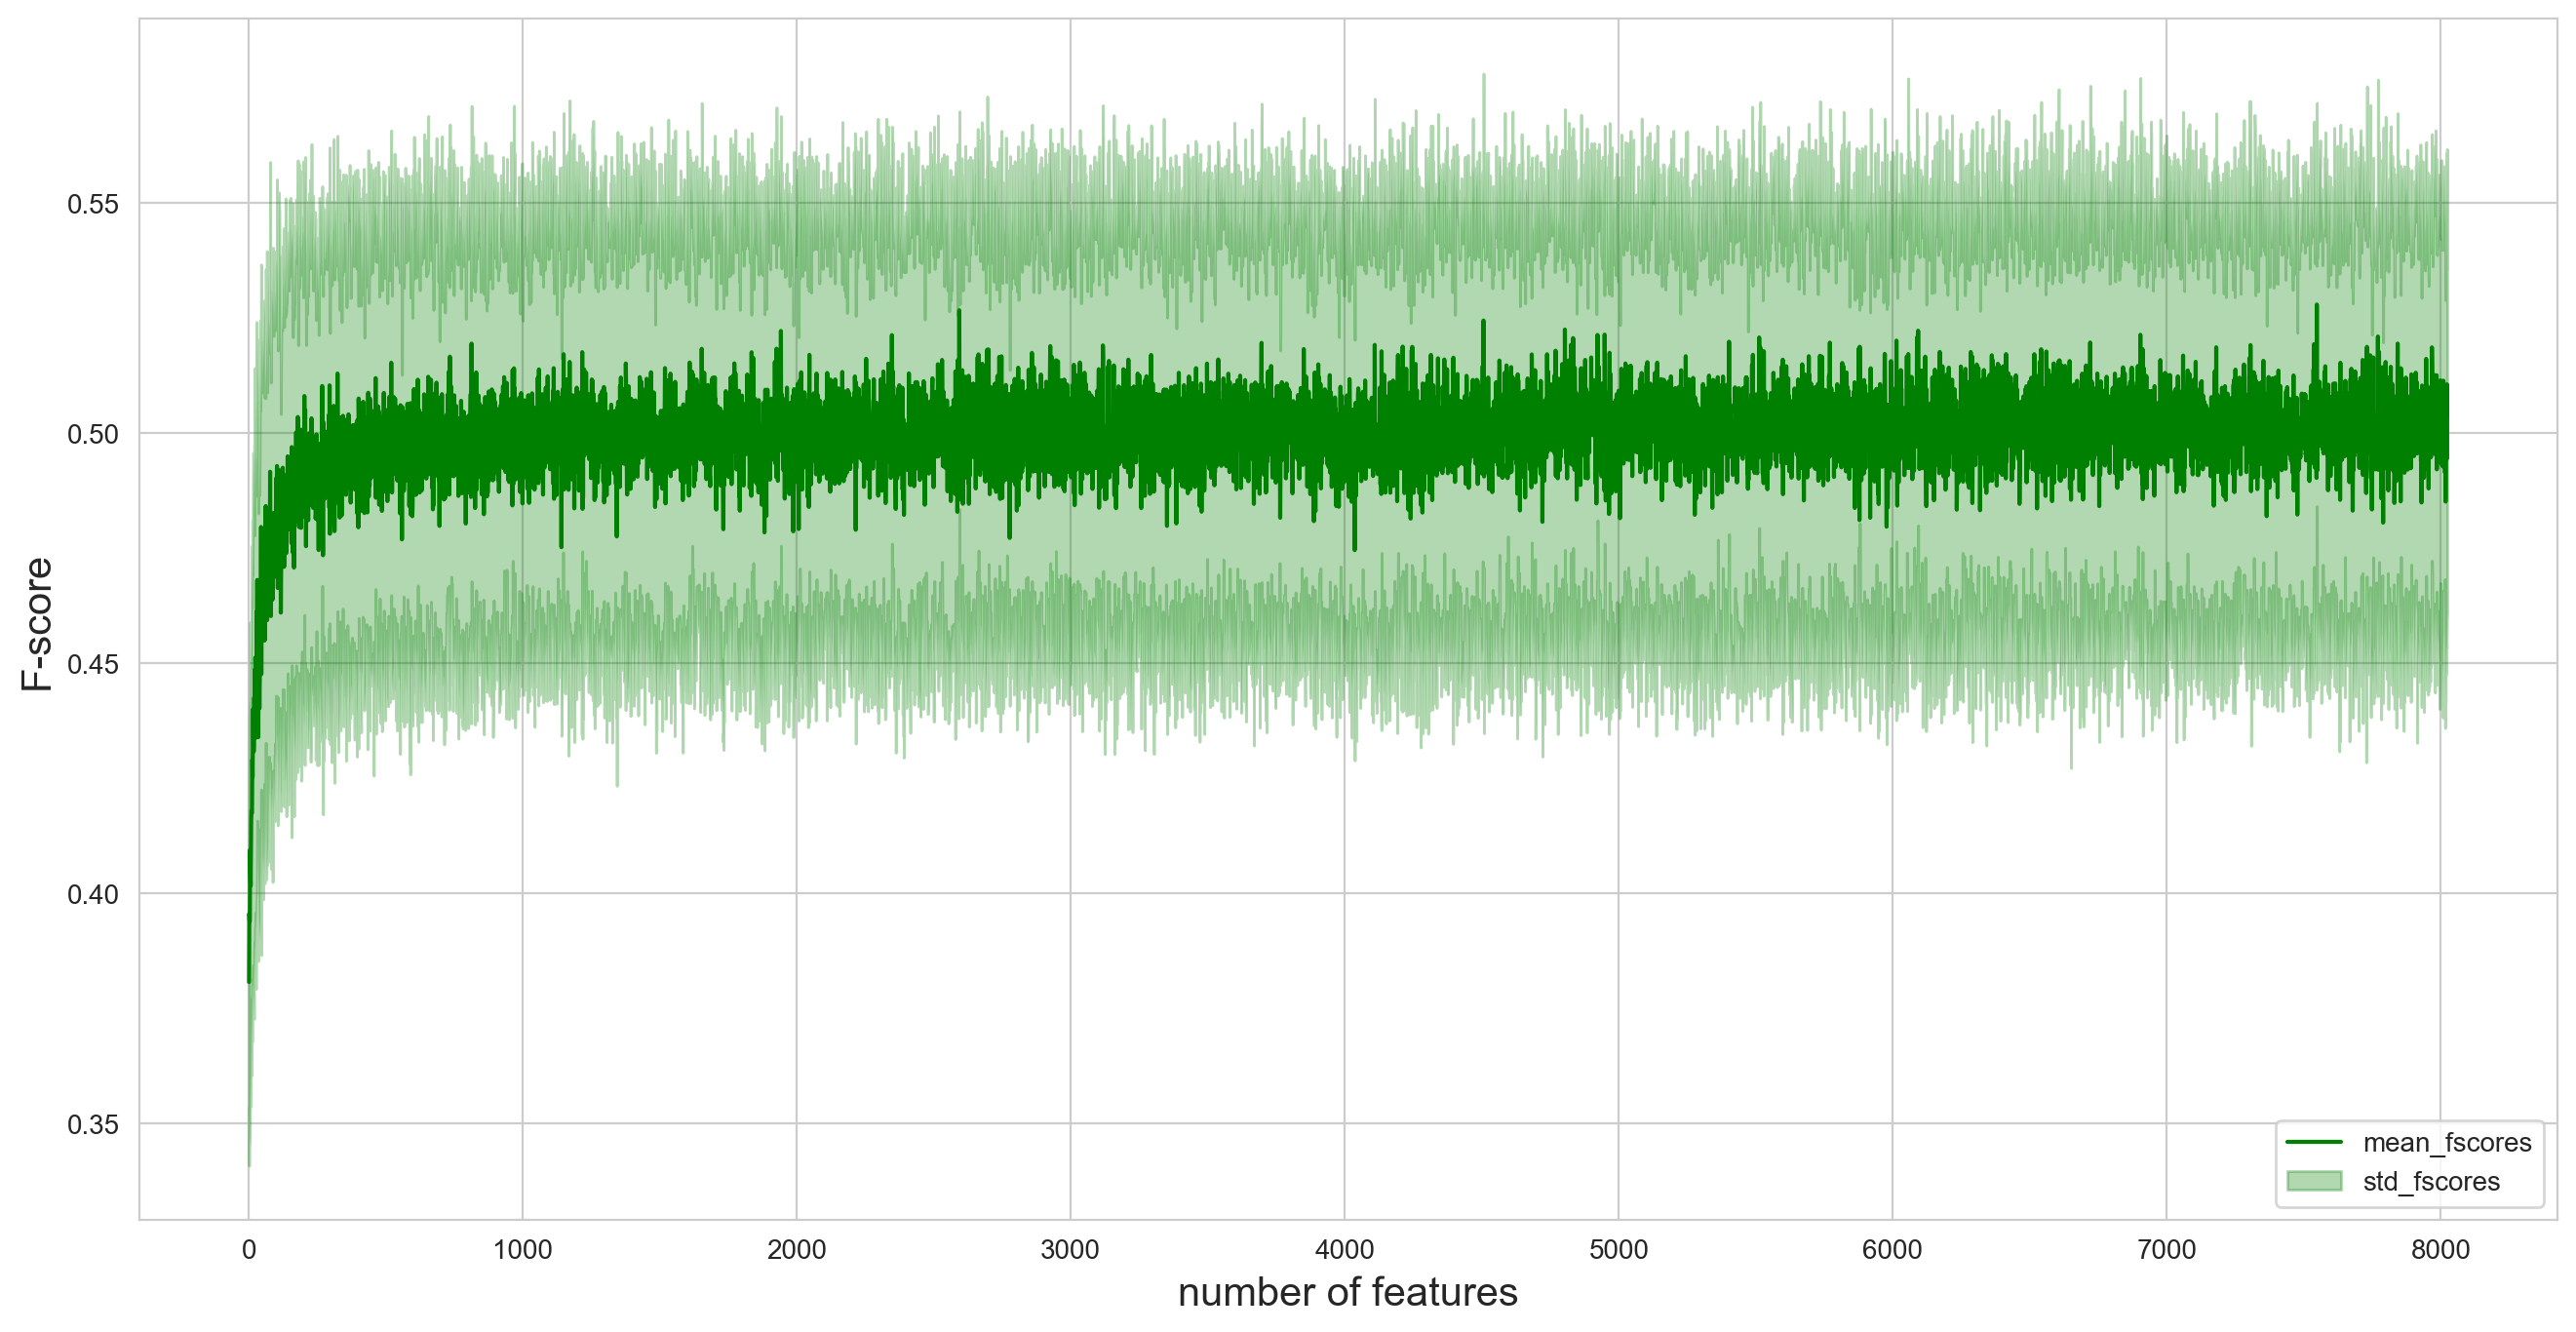

In [130]:
# plt.figure(figsize=(16, 8), dpi=200)
# plot_bandperformance(scores, 'fscore', min_x=0, max_x=2000)
# plt.figure(figsize=(16, 8), dpi=200)
# plot_bandperformance(scores, 'fscore', min_x=2000, max_x=4000)
# plt.figure(figsize=(16, 8), dpi=200)
# plot_bandperformance(scores, 'fscore', min_x=4000, max_x=6000)
# plt.figure(figsize=(16, 8), dpi=200)
# plot_bandperformance(scores, 'fscore', min_x=6000, max_x=scores.shape[0])

plt.figure(figsize=(16, 8), dpi=200)
plot_bandperformance(scores, 'fscore', min_x=0, max_x=scores.shape[0])

In [140]:
np.argmax(scores['mean_Fscore_list'])

7546

In [141]:
scores

,mean_prec_list,std_prec_list,mean_rec_list,std_rec_list,mean_Fscore_list,std_Fscore_list
0,0.397292,0.056682,0.368193,0.040474,0.380735,0.039904
1,0.410340,0.059526,0.384372,0.037703,0.395635,0.041901
2,0.402341,0.060048,0.387285,0.042353,0.393924,0.047184
3,0.399739,0.059521,0.389563,0.042944,0.393900,0.047933
4,0.418539,0.066028,0.403522,0.047020,0.409459,0.049412
...,...,...,...,...,...,...
18,0.500014,0.054088,0.497812,0.049512,0.498751,0.051156
19,0.510172,0.057911,0.504954,0.050247,0.507388,0.053438
20,0.495002,0.043912,0.493920,0.039712,0.494329,0.041164
21,0.516396,0.061509,0.506162,0.048311,0.510588,0.051107


In [137]:
for permu in itertools.permutations(X_scaled.columns, 7546):
    print(permu)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)


KeyboardInterrupt



In [91]:
# np.random.seed(42)
#
# max_nb_feat = 11
# nb_test = 50
#
# mean_prec_list, std_prec_list = [], []
# mean_rec_list, std_rec_list = [], []
# mean_Fscore_list, std_Fscore_list = [], []
# for num_feature in range(1, max_nb_feat+1):
#     prec_list, rec_list, Fscore_list = [], [], []
#     for i in range(nb_test):
#         tic = time.time()
#         gauss = np.random.normal(0,1, len(Y))
#         gauss = gauss.reshape(-1, len(gauss)).T
#         k_means = KMeans(n_clusters=4).fit(gauss)
#         pred = k_means.labels_
#         y_pred = get_dataframe(pred, Y)
#         _, fscore, prec, rec = model_eval(Y, y_pred)
#
#         prec_list.append(prec)
#         rec_list.append(rec)
#         Fscore_list.append(Fscore)
#         tac = time.time()
#
#         print("[# features: %d] [random attemps: %d] [prec: %.4f] [rec: %.4f] [F-score: %.4f] [T: %.2f]" % (
#             num_feature, i, prec, rec, Fscore, (tac-tic)
#         ))
#
#     mean_error_list.append(np.mean(error_list))
#     std_error_list.append(np.std(error_list))

[# features: 1] [random attemps: 0] [prec: 0.3212] [rec: 0.3211] [F-score: 0.3632] [T: 0.59]
[# features: 1] [random attemps: 1] [prec: 0.4836] [rec: 0.3345] [F-score: 0.3632] [T: 0.41]
[# features: 1] [random attemps: 2] [prec: 0.3366] [rec: 0.3403] [F-score: 0.3632] [T: 0.34]
[# features: 1] [random attemps: 3] [prec: 0.3952] [rec: 0.3586] [F-score: 0.3632] [T: 0.29]
[# features: 1] [random attemps: 4] [prec: 0.3544] [rec: 0.3368] [F-score: 0.3632] [T: 0.21]
[# features: 1] [random attemps: 5] [prec: 0.3477] [rec: 0.3140] [F-score: 0.3632] [T: 0.23]
[# features: 1] [random attemps: 6] [prec: 0.3506] [rec: 0.3810] [F-score: 0.3632] [T: 0.21]
[# features: 1] [random attemps: 7] [prec: 0.3682] [rec: 0.3496] [F-score: 0.3632] [T: 0.24]
[# features: 1] [random attemps: 8] [prec: 0.4176] [rec: 0.4158] [F-score: 0.3632] [T: 0.20]
[# features: 1] [random attemps: 9] [prec: 0.4375] [rec: 0.4098] [F-score: 0.3632] [T: 0.27]
[# features: 1] [random attemps: 10] [prec: 0.4835] [rec: 0.3961] [F-s

### 5.2 Agglomerative Clustering

In [165]:
AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit_predict(data)

Fscor_list = []
max_Fscore = 0
feature_selected = None

for i in range(X_scaled.shape[1]):
    print(i, "/", X_scaled.shape[1])

    X_reduced = np.array(X_scaled.iloc[:, i]).reshape(-1, 1)
    pred_ = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit_predict(X_reduced)
    # pred_ = k_means.labels_
    y_pred_ = get_dataframe(pred_, Y)
    _, Fscore, prec, rec = model_eval(Y, y_pred_)
    Fscor_list.append(Fscore)

    if Fscore > max_Fscore:
        max_Fscore = Fscore
        feature_selected = X_scaled.columns[i]

print(max_Fscore)
print(feature_selected)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [166]:
pred_ = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit_predict(X_scaled)
y_pred_ = get_dataframe(pred_, Y)
_, Fscore, prec, rec = model_eval(Y, y_pred_)


In [169]:
Fscore

0.516164227378152

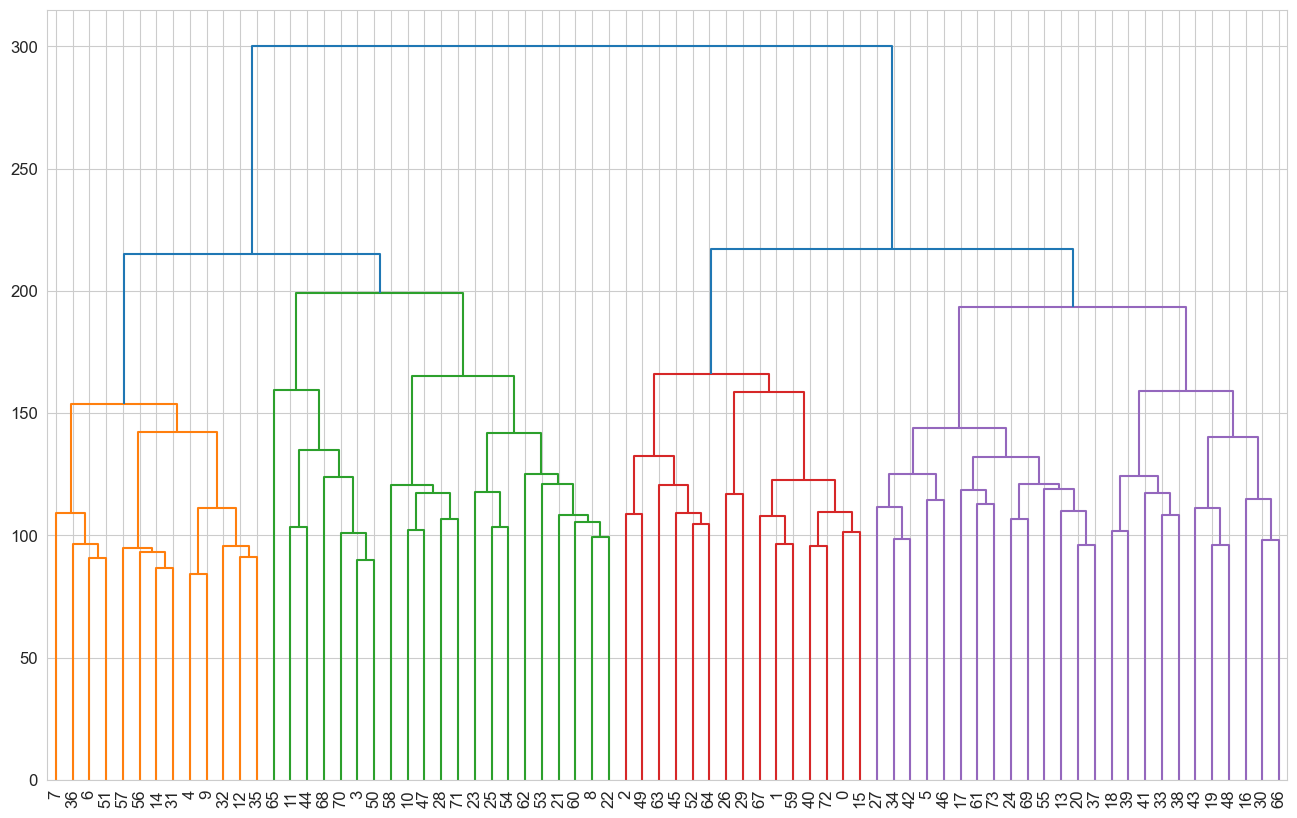

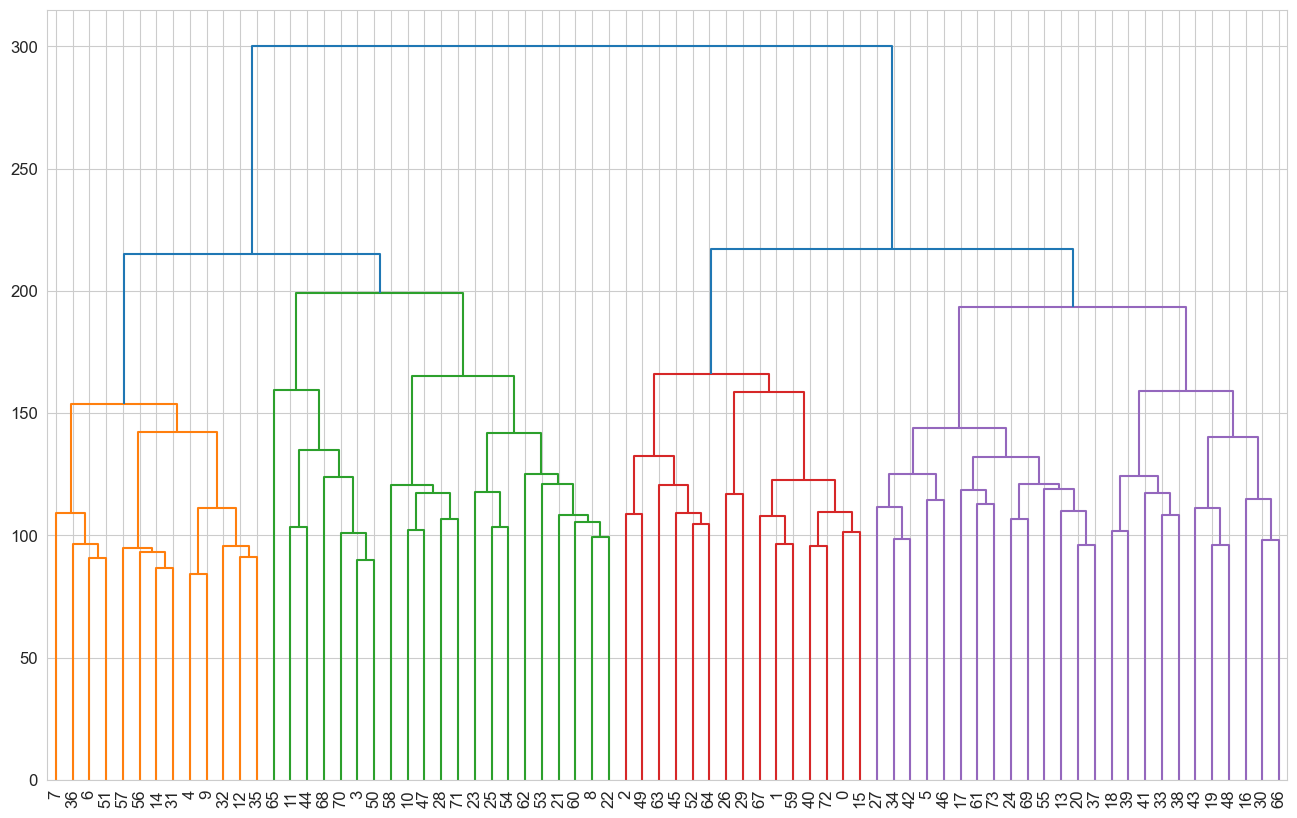

In [180]:
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 10), dpi=100)
linkage_data = linkage(X_scaled, method='ward', metric='euclidean')
dendrogram(linkage_data)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
# plt.xlabel(fontdict={'fontsize':10})
plt.show()